# Train a fully convolutional spot detection model
This notebook doesn't use the training function train_model_dot, and instead the code it contains is in this notebook.
This allows more control over the training, for example in setting different loss funcitons.

In [1]:
import datetime
import os
import errno

import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from deepcell import losses
from deepcell import image_generators
from deepcell.utils import train_utils
from deepcell.utils.train_utils import rate_scheduler

from deepcell import dot_losses
from deepcell import dot_image_generators

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Load the training data

In [2]:
from deepcell.utils import get_data

# Load the data from an npz file
npz_folder = r'/data/simulated_dots/'
filename = 'simulated_dots.npz'
DATA_DIR = '/data/simulated_dots/npz_data'
DATA_FILE = os.path.join(npz_folder,filename)

### Set up filepath constants, create directories for saving model and log

In [3]:
# Set up required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = r'/data'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
print('model dir: ', MODEL_DIR)
print('log dir: ', LOG_DIR)

model dir:  /data
log dir:  /data


### Set up training parameters

In [4]:
# parameters for reading the training data, splitting it into train and test sets
dataset = DATA_FILE # path to npz file containing the training data
expt='' # Experiment, substring to include in model name.

# train-test split parameters
test_size=.1 # Percent of data to leave as test data.
seed=0 # Random seed used for train-test split

# parameters for saving output
log_dir=LOG_DIR
model_dir=MODEL_DIR
model_name = 'conv_dots_model' # name the model for saving the trained model

# fully convolutional network structure parameters
n_skips = 3  # number of skip-connections
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

# training parameters
n_epoch = 10  # Number of training epochs
batch_size = 1  # FC training uses 1 image per batch
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99) #lr_sched=rate_scheduler(lr=0.01, decay=0.95) ???? check DECAY
num_gpus=None # The number of GPUs to train on.

# loss parameters
focal=False # If true, uses focal loss.
sigma=3.0 # The point where the loss changes from L2 to L1.
alpha=0.25 # Scale the focal weight with alpha.
gamma=0.5 # Parameter for focal loss (Take the power of the focal weight with gamma.)

# data augmentation parameters
rotation_range=180 # Maximum rotation range for image augmentation
flip=True # Enables horizontal and vertical flipping for augmentation
shear=0 # Maximum rotation range for image augmentation
zoom_range=(0.8,1.2) # Minimum and maximum zoom values (0.8, 1.2)
fill_mode='reflect' # padding style for data augmentation (input parameter of tf.keras.preprocessing.image.ImageDataGenerator). Possible values: "constant", "nearest", "reflect" or "wrap"
cval=0. #  used for pixels outside the boundaries of the input image when fill_mode='constant'

load the training data from an npz file

In [5]:
# train-test split
train_dict, test_dict = get_data(dataset, test_size=test_size, seed=seed, allow_pickle=True)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (90, 128, 128, 1)
y.shape: (90,)


### Instantiate the model

In [6]:
from deepcell.model_zoo.dotnet import dot_net_2D

model = dot_net_2D(receptive_field=receptive_field,
                   input_shape=tuple(X_train.shape[1:]),
                   inputs=None,
                   n_skips=n_skips,
                   norm_method=norm_method,
                   padding_mode='reflect')

# print(dots_model.summary())

[128, 128, 128]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
is_channels_first = K.image_data_format() == 'channels_first'
print('is_channels_first =', is_channels_first)

is_channels_first = False


In [8]:
n_classes = model.layers[-1].output_shape[1 if is_channels_first else -1]

print('X_train shape:', train_dict['X'].shape)
print('y_train shape:', train_dict['y'].shape)
print('X_test shape:', test_dict['X'].shape)
print('y_test shape:', test_dict['y'].shape)
print('Output Shape:', model.layers[-1].output_shape)
print('Number of Classes:', n_classes)

X_train shape: (90, 128, 128, 1)
y_train shape: (90,)
X_test shape: (10, 128, 128, 1)
y_test shape: (10,)
Output Shape: (None, 128, 128, 2)
Number of Classes: 2


### Set output file names

In [9]:
# set file name and path for saving the trained model and info about it
if model_name is None:
    todays_date = datetime.datetime.now().strftime('%Y-%m-%d')
    data_name = os.path.splitext(os.path.basename(dataset))[0]
    model_name = '{}_{}_{}'.format(todays_date, data_name, expt)
model_path = os.path.join(model_dir, '{}.h5'.format(model_name))
loss_path = os.path.join(model_dir, '{}.npz'.format(model_name))

print('model_path: ', model_path)
print('loss_path: ', loss_path)

model_path:  /data/conv_dots_model.h5
loss_path:  /data/conv_dots_model.npz


### Train the model

number of GPUs to train on:

In [10]:
if num_gpus is None:
    num_gpus = train_utils.count_gpus()

if num_gpus >= 2:
    batch_size = batch_size * num_gpus
    model = train_utils.MultiGpuModel(model, num_gpus)

print('Training on {} GPUs'.format(num_gpus))

Training on 1 GPUs


### set loss functions, compile model

In [11]:
# dotnet_losses = dot_losses.DotNetLosses(sigma=sigma, alpha=alpha, gamma=gamma, focal=focal)

# loss = {
#     'offset_regression': dotnet_losses.regression_loss,
#     'classification': dotnet_losses.classification_loss
# }

# loss_weights = {"offset_regression": 1.0, "classification": 1.0}
# model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])

In [12]:
# TRY ALTERNATIVE LOSS
from deepcell import losses

def wce(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred, n_classes=2)

def dc_smooth_l1(y_true, y_pred):
    return losses.smooth_l1(y_true, y_pred, sigma=3.0)

loss = {
    'offset_regression': dc_smooth_l1,
    'classification': wce
}
loss_weights = {"offset_regression": 1.0, "classification": 1.0}
model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


create ImageFullyConvDataGenerator objects for train and test sets

In [13]:
from deepcell import dot_image_generators

# this will do preprocessing and realtime data augmentation
# create DataGenerator object for generating augmented training data
datagen = dot_image_generators.ImageFullyConvDotDataGenerator(
    rotation_range=rotation_range,
    shear_range=shear,
    zoom_range=zoom_range,
    horizontal_flip=flip,
    vertical_flip=flip)

# DataGenerator object for validation data - generates data with no augmentation
datagen_val = dot_image_generators.ImageFullyConvDotDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

In [14]:
train_data = datagen.flow(
            train_dict,
            seed=seed,
            batch_size=batch_size)

val_data = datagen_val.flow(
    test_dict,
    seed=seed,
    batch_size=batch_size)

In [102]:
## test look at batch data ##
# nd = train_data.next()
# print('raw data: ', nd[0].shape)
# print('number of output heads: ', len(nd[1]))
# print('shape of each output head batch: ', nd[1][0].shape)

raw data:  (1, 128, 128, 1)
number of output heads:  2
shape of each output head batch:  (1, 128, 128, 2)


### Train the model

In [17]:
# fit the model on the batches generated by datagen.flow()
loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            model_path, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=num_gpus >= 2),
        callbacks.TensorBoard(log_dir=os.path.join(log_dir, model_name))
    ])

Epoch 1/10
10/90 [==>...........................] - ETA: 46s - loss: 23.7026 - offset_regression_loss: 21.6555 - classification_loss: 2.0277 - offset_regression_acc: 0.5638 - classification_acc: 0.9984
Epoch 00001: val_loss improved from inf to 23.70263, saving model to /data/conv_dots_model.h5
90/90 [==============================] - 34s 374ms/step - loss: 24.1908 - offset_regression_loss: 24.0226 - classification_loss: 0.1490 - offset_regression_acc: 0.5390 - classification_acc: 0.9458 - val_loss: 23.7026 - val_offset_regression_loss: 21.6555 - val_classification_loss: 2.0277 - val_offset_regression_acc: 0.5638 - val_classification_acc: 0.9984
Epoch 2/10
10/90 [==>...........................] - ETA: 45s - loss: 20.3671 - offset_regression_loss: 20.0912 - classification_loss: 0.2562 - offset_regression_acc: 0.6991 - classification_acc: 0.9906
Epoch 00002: val_loss improved from 23.70263 to 20.36713, saving model to /data/conv_dots_model.h5
90/90 [==============================] - 27s 

### Run the model

#### Make predictions on test data

In [18]:
y_pred_test = model.predict(X_test)
print(len(X_test))
print('test image result shape:', y_pred_test[0].shape)

10
test image result shape: (10, 128, 128, 2)


## Plot raw predictions

<IPython.core.display.Javascript object>


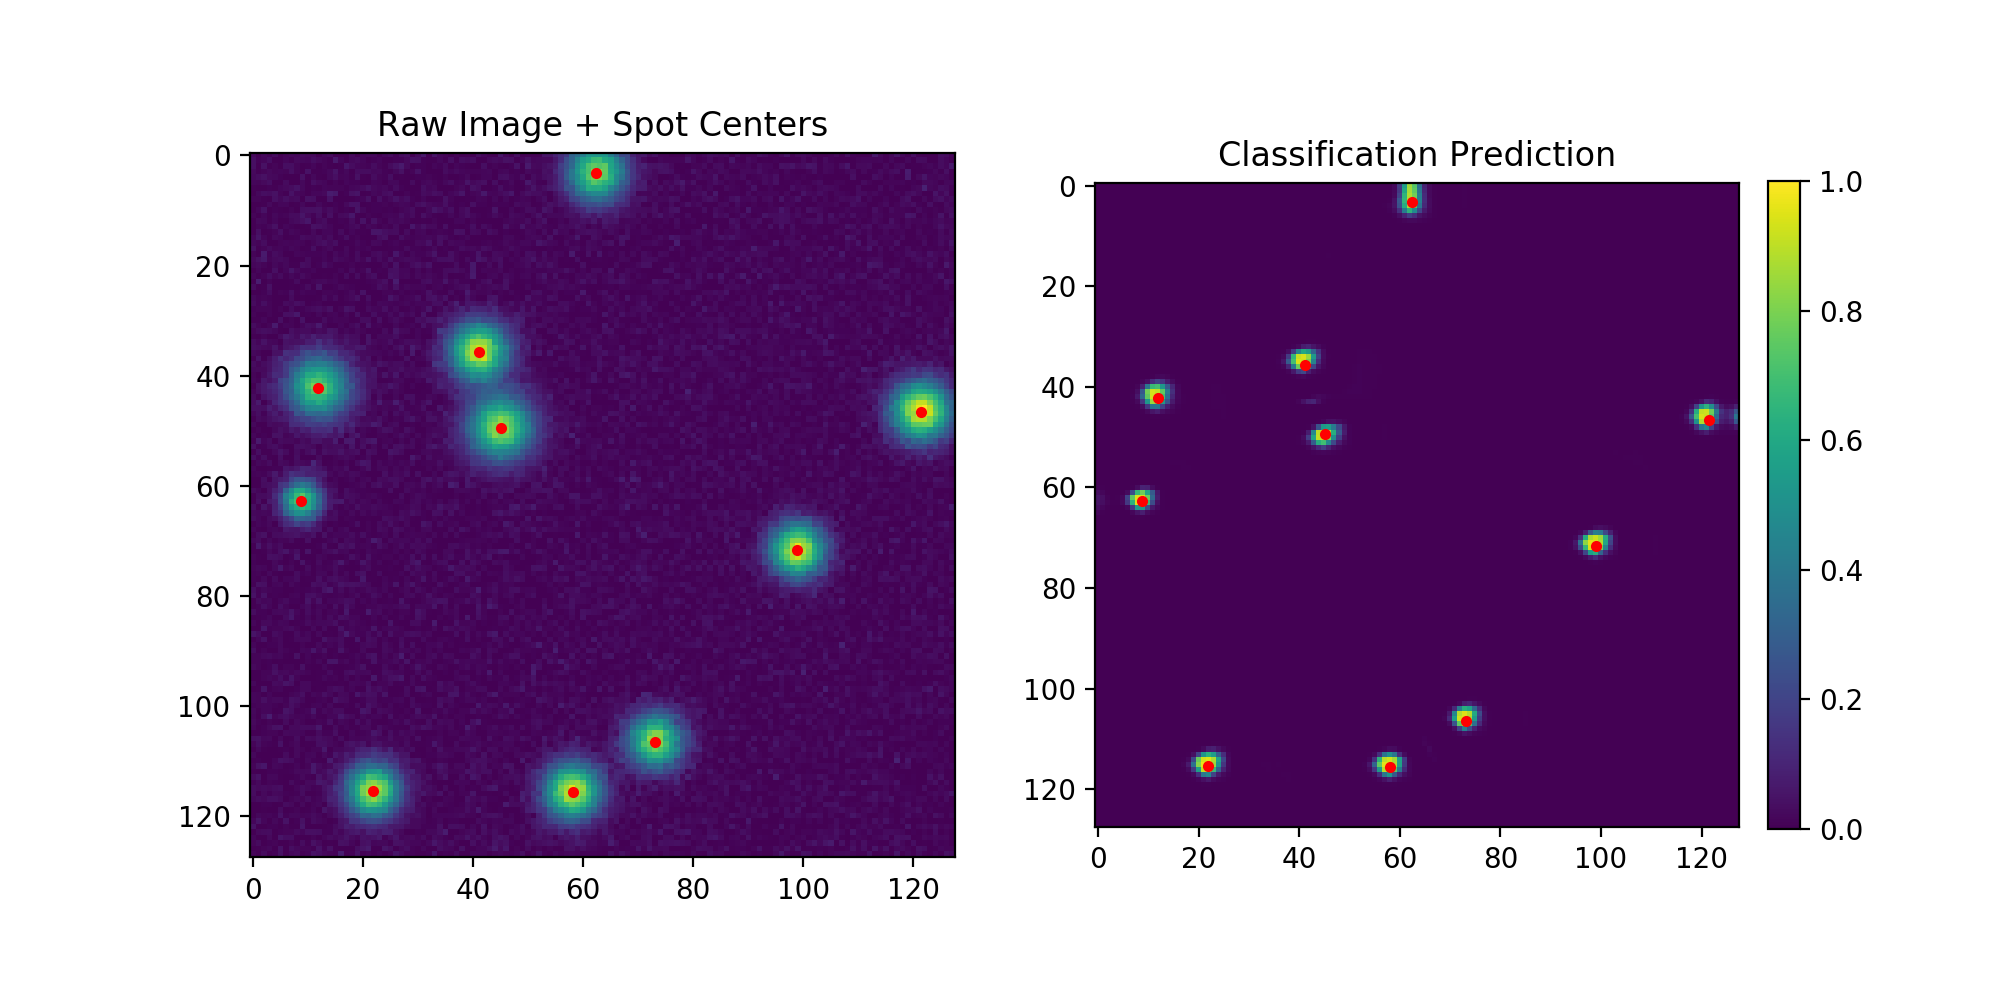

In [100]:
import matplotlib.pyplot as plt

## plot raw data, ground truth annotation vs classification results
ind = 0

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
plt.imshow(X_test[ind,...,0])
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')
plt.title('Raw Image + Spot Centers')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
plt.imshow(y_pred_test[1][ind,...,1], vmin=0, vmax=1)
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')
plt.title('Classification Prediction')
plt.colorbar(fraction=0.046, pad=0.04);

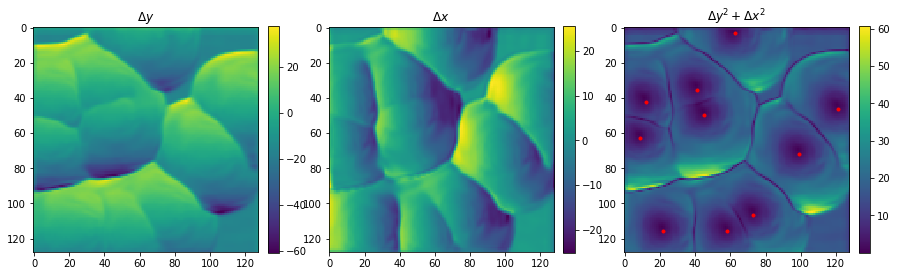

In [101]:
%matplotlib inline
# plot regression results
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(y_pred_test[0][ind,...,0])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('$\Delta y$')
plt.subplot(1,3,2)
plt.imshow(y_pred_test[0][ind,...,1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('$\Delta x$')

plt.subplot(1,3,3)
d = np.sqrt(y_pred_test[0][ind,...,0]**2 + y_pred_test[0][ind,...,1]**2)
plt.imshow(d)
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('$sqrt(\Delta y^2 + \Delta x^2)$');

#### post-processing

In [86]:
def y_annotations_to_point_list(y_pred, ind, threshold):
    """ Convert raw prediction to a predicted point list
    
    Args:
    y_pred: a batch of predictions, of the format: y_pred[annot_type][ind] is an annotation for image #ind in the batch
    where annot_type = 0 or 1: 0 - contains_dot, 1 - offset matrices
    
    ind: the index of the image in the batch for which to convert the annotations
    
    threshold: a number in [0, 1]. Pixels with classification score > threshold are considered containing a spot center,
    and their corresponding regression values will be used to create a final spot position prediction which will
    be added to the output spot center coordinates list.
    
    Returns:
    A list of spot center coordinates of the format [[y0, x0], [y1, x1],...]
    """

    contains_dot = y_pred[1][ind,...,1] > threshold
    delta_y = y_pred[0][ind,...,0]
    delta_x = y_pred[0][ind,...,1]

    dot_pixel_inds = np.argwhere(contains_dot)
    dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
    return dot_centers

In [87]:
ind = 0 # index of test image to display
threshold = 0.9 # detection threshold for classification

points_list = y_annotations_to_point_list(y_pred_test, ind, threshold)

<IPython.core.display.Javascript object>


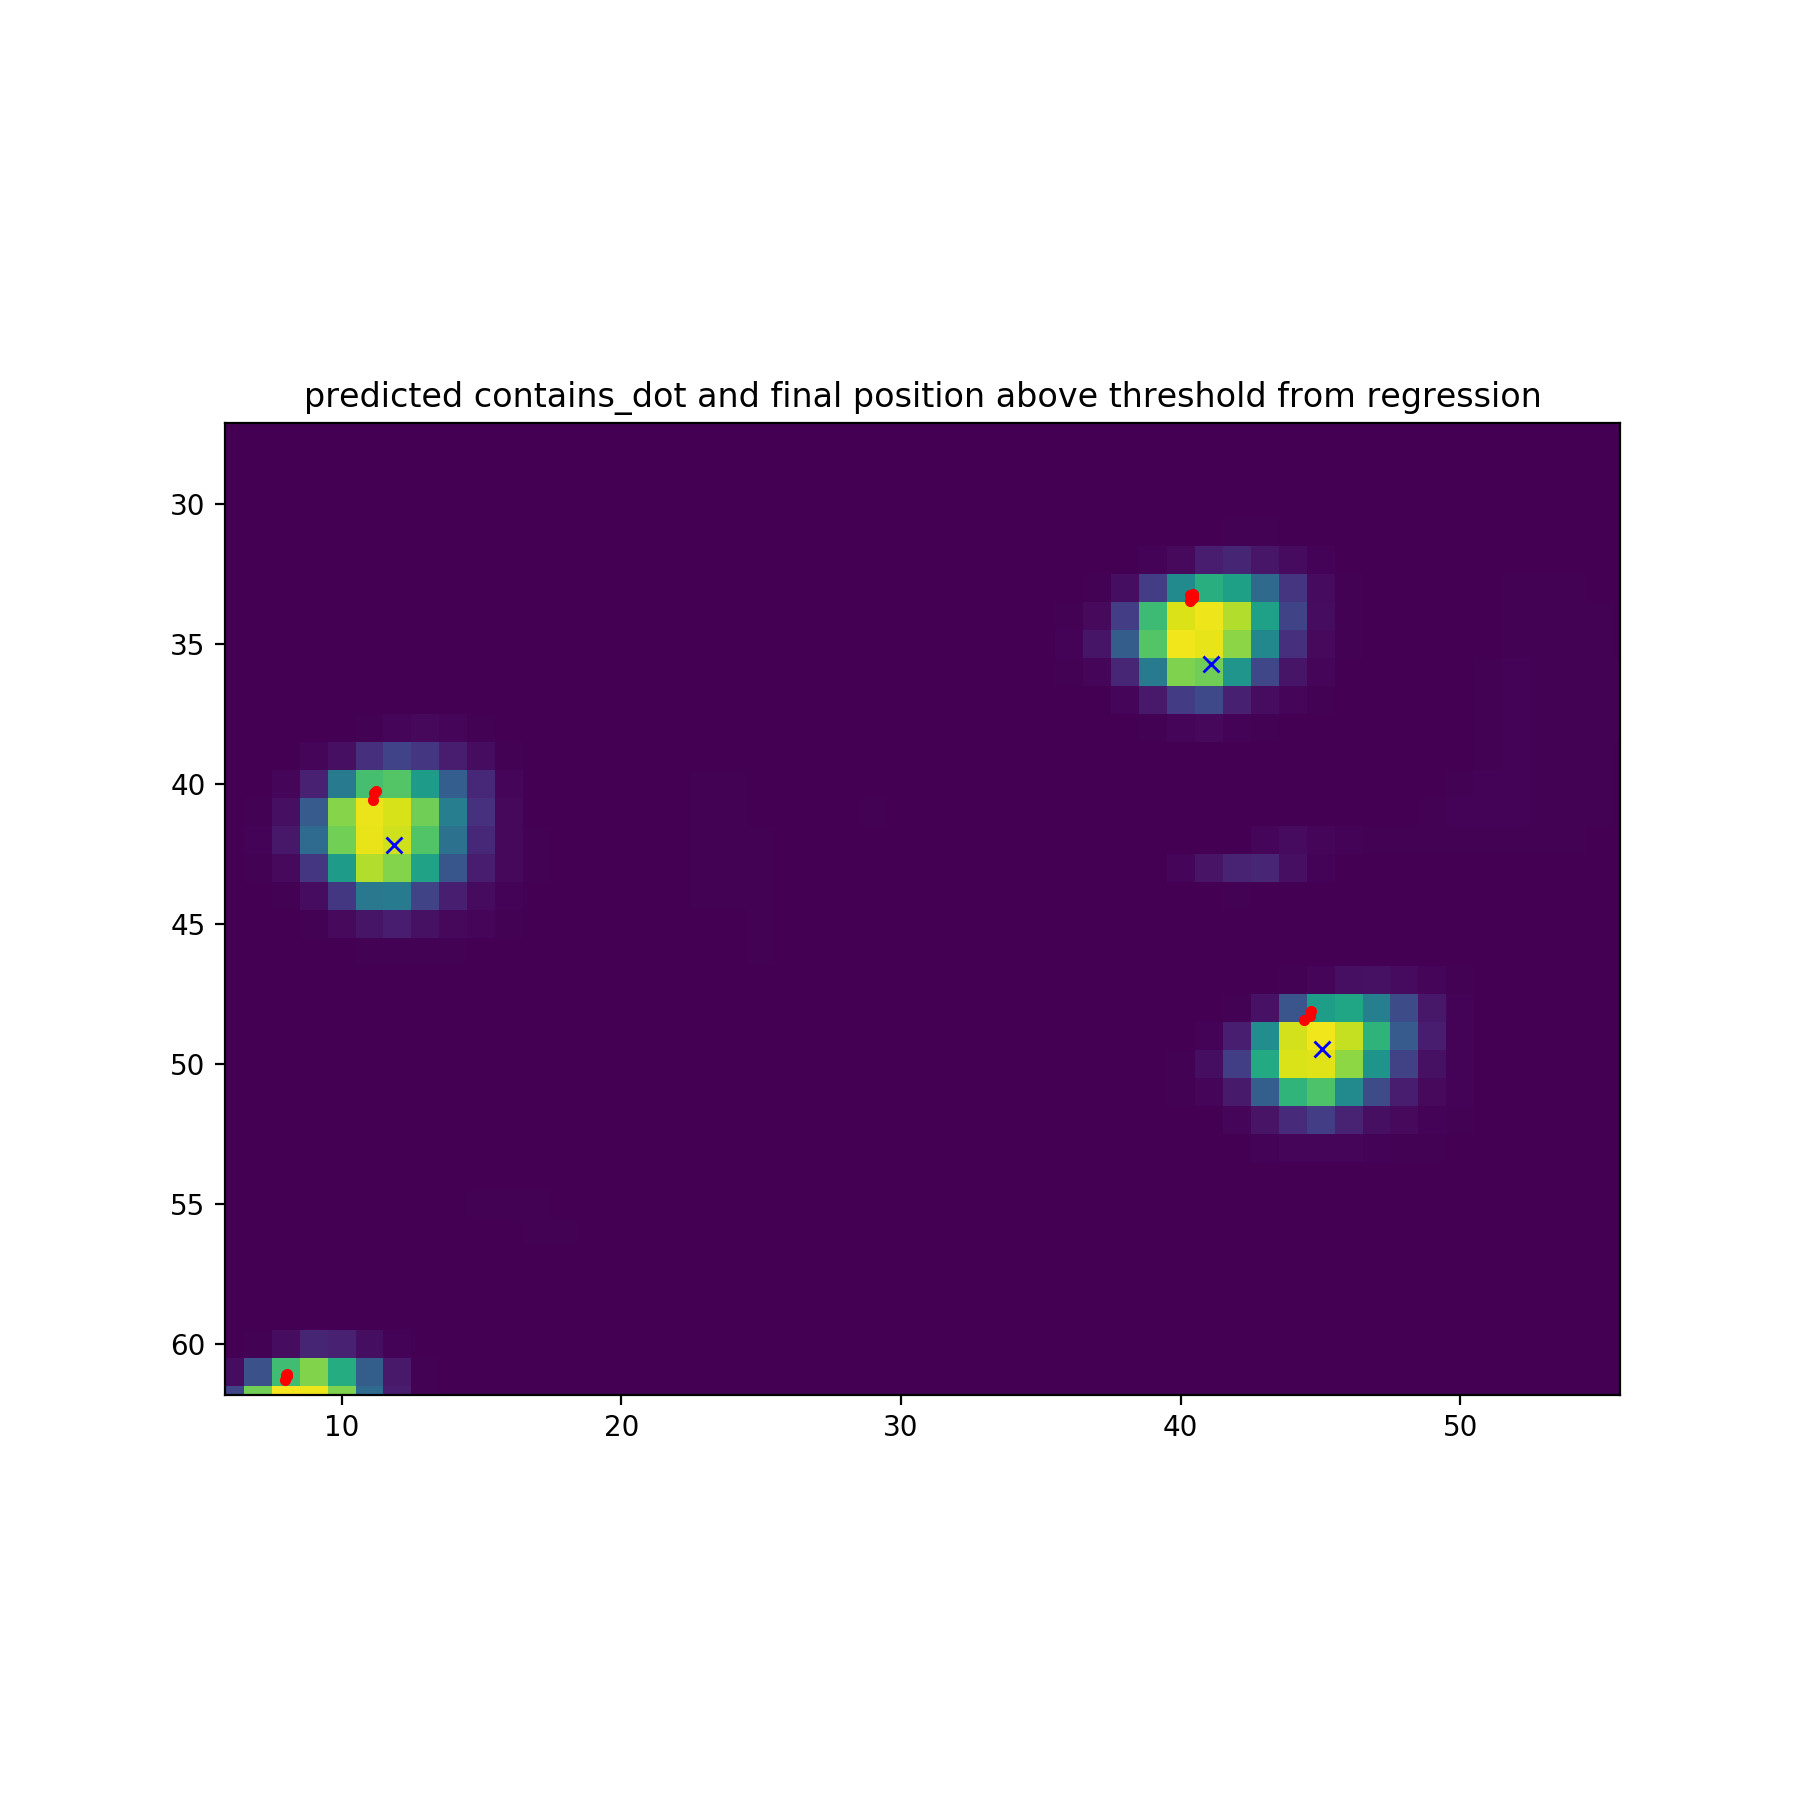

In [99]:
%matplotlib notebook
%matplotlib notebook

plt.figure(figsize=(9,9))
plt.imshow(y_pred_test[1][ind,...,1])
plt.plot(points_list[:,1], points_list[:,0],'.r')
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'xb') # plot ground truth positions
plt.title('predicted contains_dot and final position above threshold from regression');

# A more restrictive final prediction

In [26]:
def y_annotations_to_point_list2(y_pred, ind, threshold):
    # make final decision to be: classification of pixel as containing dot > threshold AND
    # center regression is contained in the pixel
    contains_dot = y_pred[1][ind,...,1] > threshold
    delta_y = y_pred[0][ind,...,0]
    delta_x = y_pred[0][ind,...,1]
    contains_its_regression = (abs(delta_x)<=0.5) & (abs(delta_y)<=0.5)
    
    final_dot_detection = contains_dot & contains_its_regression

    dot_pixel_inds = np.argwhere(final_dot_detection)
    dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
    return dot_centers

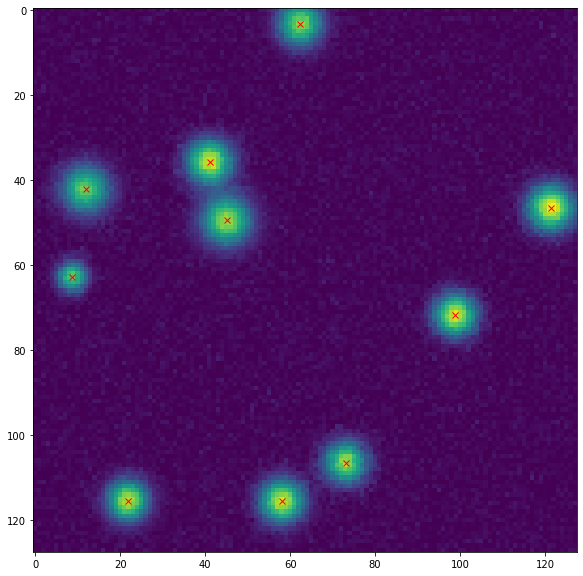

In [33]:
ind = 0
# plots results with restrictive decision
plt.figure(figsize=(10,10))
plt.imshow(X_test[ind,...,0])

# mark above threshold pixels (opaque plot over original)
threshold = 0.90
#above_thresh = y_pred_test[1][ind,...,1] > thresh
#plt.imshow(above_thresh, alpha=0.5)
points_list2 = y_annotations_to_point_list2(y_pred_test, ind, threshold)
# plot ground truth centers, and predictions
if points_list2.size!=0: # if list of detected points isn't empty
    plt.plot(points_list2[:,1], points_list2[:,0],'.',color='white')
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'xr')